In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
rm -r train_data

In [1]:
import os
import shutil
# Function to move rgb and labels to folders train_data and test_data
def move_files(source_folder, destination_folder):
    
    os.makedirs(destination_folder, exist_ok=True)
    for folder_name in os.listdir(source_folder):
        labels_path = os.path.join(source_folder, folder_name, 'labels.png')
        rgb_path = os.path.join(source_folder, folder_name, 'rgb.jpg')
        if os.path.isfile(labels_path) and os.path.isfile(rgb_path):
            destination_label_folder = os.path.join(destination_folder, 'label')
            destination_rgb_folder = os.path.join(destination_folder, 'rgb')

            os.makedirs(destination_label_folder, exist_ok=True)
            os.makedirs(destination_rgb_folder, exist_ok=True)

          
            shutil.copy(labels_path, os.path.join(destination_label_folder, f'{folder_name}.png'))
            shutil.copy(rgb_path, os.path.join(destination_rgb_folder, f'{folder_name}.jpg'))

            

          
move_files('/kaggle/input/yamaha/yamaha_v0/train','/kaggle/working/train_data/')


In [2]:
import os

folder_path = '/kaggle/working/train_data/rgb/'

# Get a list of all files in the folder
files = os.listdir(folder_path)

# Filter out non-image files if needed (e.g., only keep files with certain extensions like '.jpg', '.png')
image_files = [file for file in files if file.lower().endswith(('.jpg', '.jpeg', '.png'))]

# Sort the image files alphabetically
sorted_image_files = sorted(image_files)

folder_path = '/kaggle/working/train_data/label/'

# Get a list of all files in the folder
files_l = os.listdir(folder_path)

# Filter out non-image files if needed (e.g., only keep files with certain extensions like '.jpg', '.png')
image_files_l = [file for file in files_l if file.lower().endswith(('.jpg', '.jpeg', '.png'))]

# Sort the image files alphabetically
sorted_label_files = sorted(image_files_l)

# If you want to sort based on file modification time, you can use os.path.getmtime
# sorted_image_files = sorted(image_files, key=lambda x: os.path.getmtime(os.path.join(folder_path, x)))

# Now sorted_image_files contains the names of the image files in sorted order

print(sorted_image_files[100])
print(sorted_label_files[100])

iid000158.jpg
iid000158.png


In [3]:

source_folder = '/kaggle/input/yamaha/yamaha_v0/train/'
destination_folder = '/kaggle/working/train_data'
move_files(source_folder, destination_folder)

In [4]:
def unnorm(img, mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]):
    for t, m, s in zip(img, mean, std):
        t.mul_(s).add_(s)
        
    return img

In [5]:

from glob import glob
import itertools
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import PIL
from PIL import Image
import random
import shutil
from sklearn.model_selection import GroupKFold
from sklearn.metrics import roc_curve
from sklearn import metrics
import time
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
from torch.utils.data import Dataset, random_split, DataLoader

import torchvision.models as models
import torchvision.transforms as transforms
import cv2

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [6]:
class ImageDataset(Dataset):
    def __init__(self, monet_dir, photo_dir, size=(256, 256), normalize=True):
        super().__init__()
        self.monet_dir = monet_dir
        self.photo_dir = photo_dir
        self.monet_idx = sorted_label_files
        self.photo_idx = sorted_image_files
        if normalize:
            self.photo_transform = transforms.Compose([
                transforms.Resize(size),
                transforms.ToTensor(),
                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))                                
            ])
            self.monet_transform = transforms.Compose([
                transforms.Resize(size),
                transforms.ToTensor(),
                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))                               
            ])
        else:
            self.transform = transforms.Compose([
                transforms.Resize(size),
                transforms.ToTensor()                               
            ])
        for i, fl in enumerate(os.listdir(self.monet_dir)):
            self.monet_idx[i] = fl
        for i, fl in enumerate(os.listdir(self.photo_dir)):
            self.photo_idx[i] = fl

    def __getitem__(self, idx):
        rand_idx = int(np.random.uniform(0, len(sorted_label_files)))
        photo_path = os.path.join(self.photo_dir, self.photo_idx[rand_idx])
        last_name=photo_path.split('/')
        monet_path = os.path.join(self.monet_dir, last_name[-1][:-3]+'png')
      
        photo_img = Image.open(photo_path)
        photo_img = self.photo_transform(photo_img)
        monet_img = Image.open(monet_path)
        monet_img = monet_img.convert("RGB")
        monet_img = self.monet_transform(monet_img)
        
        return photo_img, monet_img

    def __len__(self):
        return min(len(self.monet_idx), len(self.photo_idx))


In [7]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [8]:
img_ds = ImageDataset('/kaggle/working/train_data/label/', '/kaggle/working/train_data/rgb/')

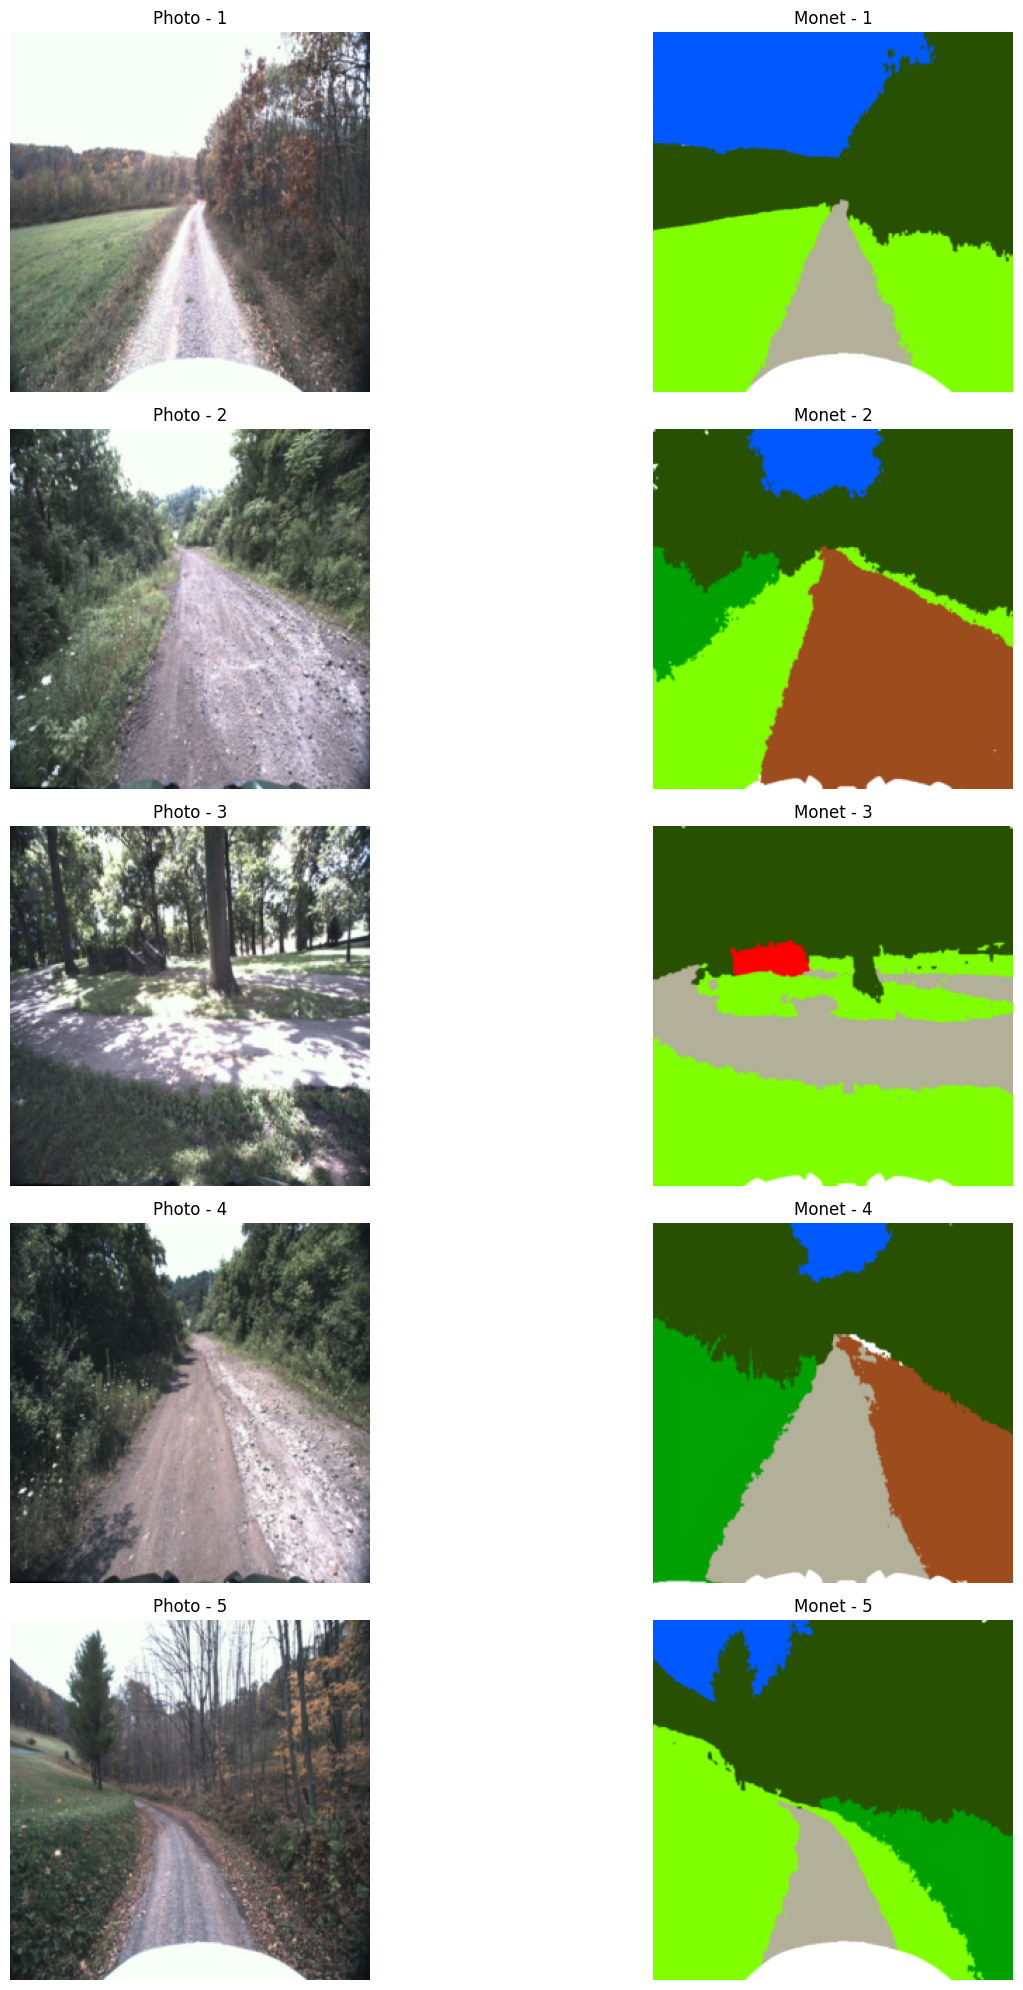

In [9]:
import matplotlib.pyplot as plt

# Assuming you have the necessary imports and definitions for DataLoader and unnorm

# Set up your data loader
img_dl = DataLoader(img_ds, batch_size=1, pin_memory=True)

# Create a figure with 5 rows and 2 columns of subplots
f, axes = plt.subplots(5, 2, figsize=(16, 20))

# Iterate over the data loader to get five batches of images
for i in range(5):
    # Get the next batch
    photo_img, monet_img = next(iter(img_dl))

    # Unnormalize the images
    photo_img = unnorm(photo_img)
    monet_img = unnorm(monet_img)

    # Display the "Photo" image
    axes[i, 0].imshow(photo_img[0].permute(1, 2, 0))
    axes[i, 0].set_title(f'Photo - {i+1}')
    axes[i, 0].axis('off')

    # Display the "Monet" image
    axes[i, 1].imshow(monet_img[0].permute(1, 2, 0))
    axes[i, 1].set_title(f'Monet - {i+1}')
    axes[i, 1].axis('off')

# Adjust layout to prevent overlapping
plt.tight_layout()

# Show the plot
plt.show()


In [10]:
def load_checkpoint(ckpt_path, map_location=None):
    ckpt = torch.load(ckpt_path, map_location=map_location)
    print(' [*] Loading checkpoint from %s succeed!' % ckpt_path)
    return ckpt
def save_checkpoint(state, save_path):
    torch.save(state, save_path)
def init_weights(net, init_type='normal', gain=0.02):
    def init_func(m):
        classname = m.__class__.__name__
        if hasattr(m, 'weight') and (classname.find('Conv') != -1 or classname.find('Linear') != -1):
            init.normal_(m.weight.data, 0.0, gain)
            if hasattr(m, 'bias') and m.bias is not None:
                init.constant_(m.bias.data, 0.0)
        elif classname.find('BatchNorm2d') != -1:
            init.normal_(m.weight.data, 1.0, gain)
            init.constant_(m.bias.data, 0.0)
    net.apply(init_func)

In [11]:
def Upsample(in_ch, out_ch, use_dropout=True, dropout_ratio=0.5):
    if use_dropout:
        return nn.Sequential(
            nn.ConvTranspose2d(in_ch, out_ch, 3, stride=2, padding=1, output_padding=1),
            nn.InstanceNorm2d(out_ch),
            nn.Dropout(dropout_ratio),
            nn.GELU()
        )
    else:
        return nn.Sequential(
            nn.ConvTranspose2d(in_ch, out_ch, 3, stride=2, padding=1, output_padding=1),
            nn.InstanceNorm2d(out_ch),
            nn.GELU()
        )
    
def Convlayer(in_ch, out_ch, kernel_size=3, stride=2, use_leaky=True, use_inst_norm=True, use_pad=True):
    if use_pad:
        conv = nn.Conv2d(in_ch, out_ch, kernel_size, stride, 1, bias=True)
    else:
        conv = nn.Conv2d(in_ch, out_ch, kernel_size, stride, 0, bias=True)

    if use_leaky:
        actv = nn.LeakyReLU(negative_slope=0.2, inplace=True)
    else:
        actv = nn.GELU()

    if use_inst_norm:
        norm = nn.InstanceNorm2d(out_ch)
    else:
        norm = nn.BatchNorm2d(out_ch)

    return nn.Sequential(
        conv,
        norm,
        actv
    )


class Resblock(nn.Module):
    def __init__(self, in_features, use_dropout=True, dropout_ratio=0.5):
        super().__init__()
        layers = list()
        layers.append(nn.ReflectionPad2d(1))
        layers.append(Convlayer(in_features, in_features, 3, 1, False, use_pad=False))
        layers.append(nn.Dropout(dropout_ratio))
        layers.append(nn.ReflectionPad2d(1))
        layers.append(nn.Conv2d(in_features, in_features, 3, 1, padding=0, bias=True))
        layers.append(nn.InstanceNorm2d(in_features))
        self.res = nn.Sequential(*layers)

    def forward(self, x):
        return x + self.res(x)

class Resblock(nn.Module):
    def __init__(self, in_features, use_dropout=True, dropout_ratio=0.5):
        super().__init__()
        layers = list()
        layers.append(nn.ReflectionPad2d(1))
        layers.append(Convlayer(in_features, in_features, 3, 1, False, use_pad=False))
        layers.append(nn.Dropout(dropout_ratio))
        layers.append(nn.ReflectionPad2d(1))
        layers.append(nn.Conv2d(in_features, in_features, 3, 1, padding=0, bias=True))
        layers.append(nn.InstanceNorm2d(in_features))
        self.res = nn.Sequential(*layers)

    def forward(self, x):
        return x + self.res(x)
    

class Generator(nn.Module):
    def __init__(self, in_ch, out_ch, num_res_blocks=6):
        super().__init__()
        model = list()
        model.append(nn.ReflectionPad2d(3))
        model.append(Convlayer(in_ch, 64, 7, 1, False, True, False))
        model.append(Convlayer(64, 128, 3, 2, False))
        model.append(Convlayer(128, 256, 3, 2, False))
        for _ in range(num_res_blocks):
            model.append(Resblock(256))
        model.append(Upsample(256, 128))
        model.append(Upsample(128, 64))
        model.append(nn.ReflectionPad2d(3))
        model.append(nn.Conv2d(64, out_ch, kernel_size=7, padding=0))
        model.append(nn.Tanh())

        self.gen = nn.Sequential(*model)

    def forward(self, x):
        return self.gen(x)
    
    
class Discriminator(nn.Module):
    def __init__(self, in_ch, num_layers=4):
        super().__init__()
        model = list()
        model.append(nn.Conv2d(in_ch, 64, 4, stride=2, padding=1))
        model.append(nn.LeakyReLU(0.2, inplace=True))
        for i in range(1, num_layers):
            in_chs = 64 * 2**(i-1)
            out_chs = in_chs * 2
            if i == num_layers -1:
                model.append(Convlayer(in_chs, out_chs, 4, 1))
            else:
                model.append(Convlayer(in_chs, out_chs, 4, 2))
        model.append(nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=1))
        self.disc = nn.Sequential(*model)

    def forward(self, x):
        return self.disc(x)

    
    
def update_req_grad(models, requires_grad=True):
    for model in models:
        for param in model.parameters():
            param.requires_grad = requires_grad

In [12]:
# https://arxiv.org/pdf/1612.07828.pdf
# Save 50 generated fake imgs and sample through them
# to feed discriminators to avoid large oscillations 
# from iterations to iterations.
class sample_fake(object):
    def __init__(self, max_imgs=50):
        self.max_imgs = max_imgs
        self.cur_img = 0
        self.imgs = list()

    def __call__(self, imgs):
        ret = list()
        for img in imgs:
            if self.cur_img < self.max_imgs:
                self.imgs.append(img)
                ret.append(img)
                self.cur_img += 1
            else:
                if np.random.ranf() > 0.5:
                    idx = np.random.randint(0, self.max_imgs)
                    ret.append(self.imgs[idx])
                    self.imgs[idx] = img
                else:
                    ret.append(img)
        return ret

In [13]:
class lr_sched():
    def __init__(self, decay_epochs=100, total_epochs=200):
        self.decay_epochs = decay_epochs
        self.total_epochs = total_epochs

    def step(self, epoch_num):
        if epoch_num <= self.decay_epochs:
            return 1.0
        else:
            fract = (epoch_num - self.decay_epochs)  / (self.total_epochs - self.decay_epochs)
            return 1.0 - fract
        
class AvgStats(object):
    def __init__(self):
        self.reset()
        
    def reset(self):
        self.losses =[]
        self.its = []
        
    def append(self, loss, it):
        self.losses.append(loss)
        self.its.append(it)

In [14]:

class CycleGAN(object):
    def __init__(self, in_ch, out_ch, epochs, device, start_lr=2e-4, lmbda=10, idt_coef=0.5, decay_epoch=0):
        self.epochs = epochs
        self.decay_epoch = decay_epoch if decay_epoch > 0 else int(self.epochs/2)
        self.lmbda = lmbda
        self.idt_coef = idt_coef
        self.device = device
        self.gen_mtp = Generator(in_ch, out_ch)
        self.gen_ptm = Generator(in_ch, out_ch)
        self.desc_m = Discriminator(in_ch)
        self.desc_p = Discriminator(in_ch)
        self.init_models()
        self.mse_loss = nn.MSELoss()
        self.l1_loss = nn.L1Loss()
        self.adam_gen = torch.optim.Adam(itertools.chain(self.gen_mtp.parameters(), self.gen_ptm.parameters()),
                                         lr = start_lr, betas=(0.5, 0.999))
        self.adam_desc = torch.optim.Adam(itertools.chain(self.desc_m.parameters(), self.desc_p.parameters()),
                                          lr=start_lr, betas=(0.5, 0.999))
        self.sample_monet = sample_fake()
        self.sample_photo = sample_fake()
        gen_lr = lr_sched(self.decay_epoch, self.epochs)
        desc_lr = lr_sched(self.decay_epoch, self.epochs)
        self.gen_lr_sched = torch.optim.lr_scheduler.LambdaLR(self.adam_gen, gen_lr.step)
        self.desc_lr_sched = torch.optim.lr_scheduler.LambdaLR(self.adam_desc, desc_lr.step)
        self.gen_stats = AvgStats()
        self.desc_stats = AvgStats()
        
    def init_models(self):
        init_weights(self.gen_mtp)
        init_weights(self.gen_ptm)
        init_weights(self.desc_m)
        init_weights(self.desc_p)
        self.gen_mtp = self.gen_mtp.to(self.device)
        self.gen_ptm = self.gen_ptm.to(self.device)
        self.desc_m = self.desc_m.to(self.device)
        self.desc_p = self.desc_p.to(self.device)
        
    def train(self, photo_dl):
        for epoch in range(self.epochs):
            start_time = time.time()
            avg_gen_loss = 0.0
            avg_desc_loss = 0.0
            t = tqdm(photo_dl, leave=False, total=photo_dl.__len__())
            for i, (photo_real, monet_real) in enumerate(t):
                photo_img, monet_img = photo_real.to(device), monet_real.to(device)
                update_req_grad([self.desc_m, self.desc_p], False)
                self.adam_gen.zero_grad()

                # Forward pass through generator
                fake_photo = self.gen_mtp(monet_img)
                fake_monet = self.gen_ptm(photo_img)

                cycl_monet = self.gen_ptm(fake_photo)
                cycl_photo = self.gen_mtp(fake_monet)

                id_monet = self.gen_ptm(monet_img)
                id_photo = self.gen_mtp(photo_img)

                # generator losses - identity, Adversarial, cycle consistency
                idt_loss_monet = self.l1_loss(id_monet, monet_img) * self.lmbda * self.idt_coef
                idt_loss_photo = self.l1_loss(id_photo, photo_img) * self.lmbda * self.idt_coef

                cycle_loss_monet = self.l1_loss(cycl_monet, monet_img) * self.lmbda
                cycle_loss_photo = self.l1_loss(cycl_photo, photo_img) * self.lmbda

                monet_desc = self.desc_m(fake_monet)
                photo_desc = self.desc_p(fake_photo)

                real = torch.ones(monet_desc.size()).to(self.device)

                adv_loss_monet = self.mse_loss(monet_desc, real)
                adv_loss_photo = self.mse_loss(photo_desc, real)

                # total generator loss
                total_gen_loss = cycle_loss_monet + adv_loss_monet\
                              + cycle_loss_photo + adv_loss_photo\
                              + idt_loss_monet + idt_loss_photo
                
                avg_gen_loss += total_gen_loss.item()

                # backward pass
                total_gen_loss.backward()
                self.adam_gen.step()

                # Forward pass through Descriminator
                update_req_grad([self.desc_m, self.desc_p], True)
                self.adam_desc.zero_grad()

                fake_monet = self.sample_monet([fake_monet.cpu().data.numpy()])[0]
                fake_photo = self.sample_photo([fake_photo.cpu().data.numpy()])[0]
                fake_monet = torch.tensor(fake_monet).to(self.device)
                fake_photo = torch.tensor(fake_photo).to(self.device)

                monet_desc_real = self.desc_m(monet_img)
                monet_desc_fake = self.desc_m(fake_monet)
                photo_desc_real = self.desc_p(photo_img)
                photo_desc_fake = self.desc_p(fake_photo)

                real = torch.ones(monet_desc_real.size()).to(self.device)
                fake = torch.zeros(monet_desc_fake.size()).to(self.device)

                # Descriminator losses
                # --------------------
                monet_desc_real_loss = self.mse_loss(monet_desc_real, real)
                monet_desc_fake_loss = self.mse_loss(monet_desc_fake, fake)
                photo_desc_real_loss = self.mse_loss(photo_desc_real, real)
                photo_desc_fake_loss = self.mse_loss(photo_desc_fake, fake)

                monet_desc_loss = (monet_desc_real_loss + monet_desc_fake_loss) / 2
                photo_desc_loss = (photo_desc_real_loss + photo_desc_fake_loss) / 2
                total_desc_loss = monet_desc_loss + photo_desc_loss
                avg_desc_loss += total_desc_loss.item()

                # Backward
                monet_desc_loss.backward()
                photo_desc_loss.backward()
                self.adam_desc.step()
                
                t.set_postfix(gen_loss=total_gen_loss.item(), desc_loss=total_desc_loss.item())

            save_dict = {
                'epoch': epoch+1,
                'gen_mtp': gan.gen_mtp.state_dict(),
                'gen_ptm': gan.gen_ptm.state_dict(),
                'desc_m': gan.desc_m.state_dict(),
                'desc_p': gan.desc_p.state_dict(),
                'optimizer_gen': gan.adam_gen.state_dict(),
                'optimizer_desc': gan.adam_desc.state_dict()
            }
            save_checkpoint(save_dict, 'current.ckpt')
            
            avg_gen_loss /= photo_dl.__len__()
            avg_desc_loss /= photo_dl.__len__()
            time_req = time.time() - start_time
            
            self.gen_stats.append(avg_gen_loss, time_req)
            self.desc_stats.append(avg_desc_loss, time_req)
            
            print("Epoch: (%d) | Generator Loss:%f | Discriminator Loss:%f" % 
                                                (epoch+1, avg_gen_loss, avg_desc_loss))
      
            self.gen_lr_sched.step()
            self.desc_lr_sched.step()

In [16]:
gan = CycleGAN(3, 3, 30, device)
# Save before train
save_dict = {
    'epoch': 0,
    'gen_mtp': gan.gen_mtp.state_dict(),
    'gen_ptm': gan.gen_ptm.state_dict(),
    'desc_m': gan.desc_m.state_dict(),
    'desc_p': gan.desc_p.state_dict(),
    'optimizer_gen': gan.adam_gen.state_dict(),

    'optimizer_desc': gan.adam_desc.state_dict()}
save_checkpoint(save_dict, 'init.ckpt')
gan.train(img_dl)

  0%|          | 0/931 [00:00<?, ?it/s]

Epoch: (1) | Generator Loss:7.906201 | Discriminator Loss:0.494479


  0%|          | 0/931 [00:00<?, ?it/s]

Epoch: (2) | Generator Loss:6.089371 | Discriminator Loss:0.274215


  0%|          | 0/931 [00:00<?, ?it/s]

Epoch: (3) | Generator Loss:5.530037 | Discriminator Loss:0.247482


  0%|          | 0/931 [00:00<?, ?it/s]

Epoch: (4) | Generator Loss:5.382733 | Discriminator Loss:0.226665


  0%|          | 0/931 [00:00<?, ?it/s]

Epoch: (5) | Generator Loss:5.013227 | Discriminator Loss:0.215294


  0%|          | 0/931 [00:00<?, ?it/s]

Epoch: (6) | Generator Loss:4.893749 | Discriminator Loss:0.196944


  0%|          | 0/931 [00:00<?, ?it/s]

Epoch: (7) | Generator Loss:4.856431 | Discriminator Loss:0.196495


  0%|          | 0/931 [00:00<?, ?it/s]

Epoch: (8) | Generator Loss:4.602361 | Discriminator Loss:0.200236


  0%|          | 0/931 [00:00<?, ?it/s]

Epoch: (9) | Generator Loss:4.535721 | Discriminator Loss:0.196590


  0%|          | 0/931 [00:00<?, ?it/s]

Epoch: (10) | Generator Loss:4.552682 | Discriminator Loss:0.191418


  0%|          | 0/931 [00:00<?, ?it/s]

Epoch: (11) | Generator Loss:4.307239 | Discriminator Loss:0.200278


  0%|          | 0/931 [00:00<?, ?it/s]

Epoch: (12) | Generator Loss:4.387175 | Discriminator Loss:0.155211


  0%|          | 0/931 [00:00<?, ?it/s]

Epoch: (13) | Generator Loss:4.168722 | Discriminator Loss:0.174501


  0%|          | 0/931 [00:00<?, ?it/s]

Epoch: (14) | Generator Loss:4.195477 | Discriminator Loss:0.146529


  0%|          | 0/931 [00:00<?, ?it/s]

Epoch: (15) | Generator Loss:4.073658 | Discriminator Loss:0.148658


  0%|          | 0/931 [00:00<?, ?it/s]

Epoch: (16) | Generator Loss:4.051544 | Discriminator Loss:0.139344


  0%|          | 0/931 [00:00<?, ?it/s]

Epoch: (17) | Generator Loss:4.081613 | Discriminator Loss:0.111875


  0%|          | 0/931 [00:00<?, ?it/s]

Epoch: (18) | Generator Loss:4.051983 | Discriminator Loss:0.109423


  0%|          | 0/931 [00:00<?, ?it/s]

Epoch: (19) | Generator Loss:3.988652 | Discriminator Loss:0.088512


  0%|          | 0/931 [00:00<?, ?it/s]

Epoch: (20) | Generator Loss:3.878375 | Discriminator Loss:0.100514


  0%|          | 0/931 [00:00<?, ?it/s]

Epoch: (21) | Generator Loss:3.821664 | Discriminator Loss:0.098178


  0%|          | 0/931 [00:00<?, ?it/s]

Epoch: (22) | Generator Loss:3.803039 | Discriminator Loss:0.101146


  0%|          | 0/931 [00:00<?, ?it/s]

Epoch: (23) | Generator Loss:3.716672 | Discriminator Loss:0.098319


  0%|          | 0/931 [00:00<?, ?it/s]

Epoch: (24) | Generator Loss:3.635420 | Discriminator Loss:0.099532


  0%|          | 0/931 [00:00<?, ?it/s]

Epoch: (25) | Generator Loss:3.644010 | Discriminator Loss:0.095894


  0%|          | 0/931 [00:00<?, ?it/s]

Epoch: (26) | Generator Loss:3.599693 | Discriminator Loss:0.089058


  0%|          | 0/931 [00:00<?, ?it/s]

Epoch: (27) | Generator Loss:3.605931 | Discriminator Loss:0.080183


  0%|          | 0/931 [00:00<?, ?it/s]

Epoch: (28) | Generator Loss:3.559736 | Discriminator Loss:0.070042


  0%|          | 0/931 [00:00<?, ?it/s]

Epoch: (29) | Generator Loss:3.580864 | Discriminator Loss:0.064533


  0%|          | 0/931 [00:00<?, ?it/s]

Epoch: (30) | Generator Loss:3.575076 | Discriminator Loss:0.055541


In [ ]:
!pip uninstall -y jupyterlab_widgets
!pip install jupyterlab_widgets

In [25]:

checkpoint_path = '/kaggle/input/model-cyclegan/current.ckpt'

# Load the checkpoint
checkpoint = torch.load(checkpoint_path)

# Retrieve the saved state dictionaries
epoch = checkpoint['epoch']
gen_mtp_state_dict = checkpoint['gen_mtp']
gen_ptm_state_dict = checkpoint['gen_ptm']
desc_m_state_dict = checkpoint['desc_m']
desc_p_state_dict = checkpoint['desc_p']
optimizer_gen_state_dict = checkpoint['optimizer_gen']
optimizer_desc_state_dict = checkpoint['optimizer_desc']

# Now, you can load the state dictionaries into your model and optimizer
gan.gen_mtp.load_state_dict(gen_mtp_state_dict)
gan.gen_ptm.load_state_dict(gen_ptm_state_dict)
gan.desc_m.load_state_dict(desc_m_state_dict)
gan.desc_p.load_state_dict(desc_p_state_dict)
gan.adam_gen.load_state_dict(optimizer_gen_state_dict)
gan.adam_desc.load_state_dict(optimizer_desc_state_dict)

# Optionally, move the models and optimizer to a specific device, e.g., GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
gan.gen_mtp.to(device)
gan.gen_ptm.to(device)
gan.desc_m.to(device)
gan.desc_p.to(device)
# Make sure to move optimizer state to the same device as the model
for state in gan.adam_gen.state.values():
    for k, v in state.items():
        if isinstance(v, torch.Tensor):
            state[k] = v.to(device)
for state in gan.adam_desc.state.values():
    for k, v in state.items():
        if isinstance(v, torch.Tensor):
            state[k] = v.to(device)


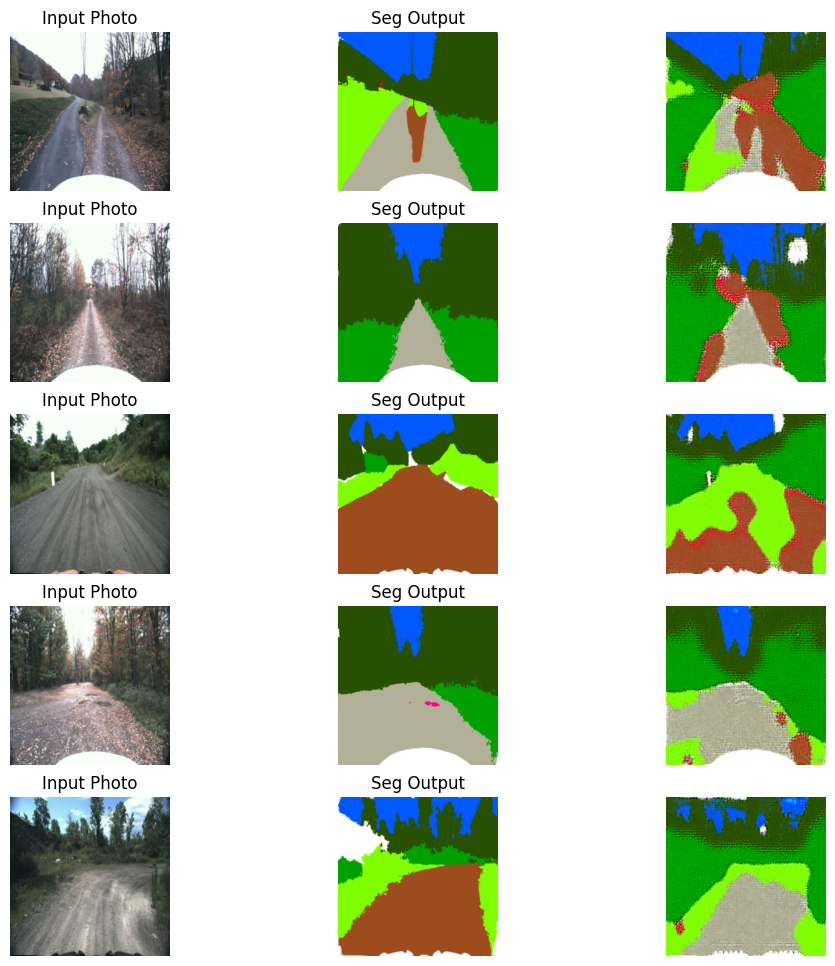

In [22]:
_, ax = plt.subplots(5, 3, figsize=(12, 12))
for i in range(5):
    photo_img, seg_img = next(iter(img_dl))
    pred_monet = gan.gen_ptm(photo_img.to(device)).cpu().detach()
    photo_img = unnorm(photo_img)
    pred_monet = unnorm(pred_monet)
    seg_img=unnorm(seg_img)
    ax[i, 0].imshow(photo_img[0].permute(1, 2, 0))
    ax[i, 1].imshow(seg_img[0].permute(1, 2, 0))
    ax[i, 2].imshow(pred_monet[0].permute(1, 2, 0))
    ax[i, 0].set_title("Input Photo")
    ax[i, 1].set_title("Seg Label")
    ax[i, 1].set_title("Seg Output")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")
    ax[i, 2].axis("off")

plt.show()

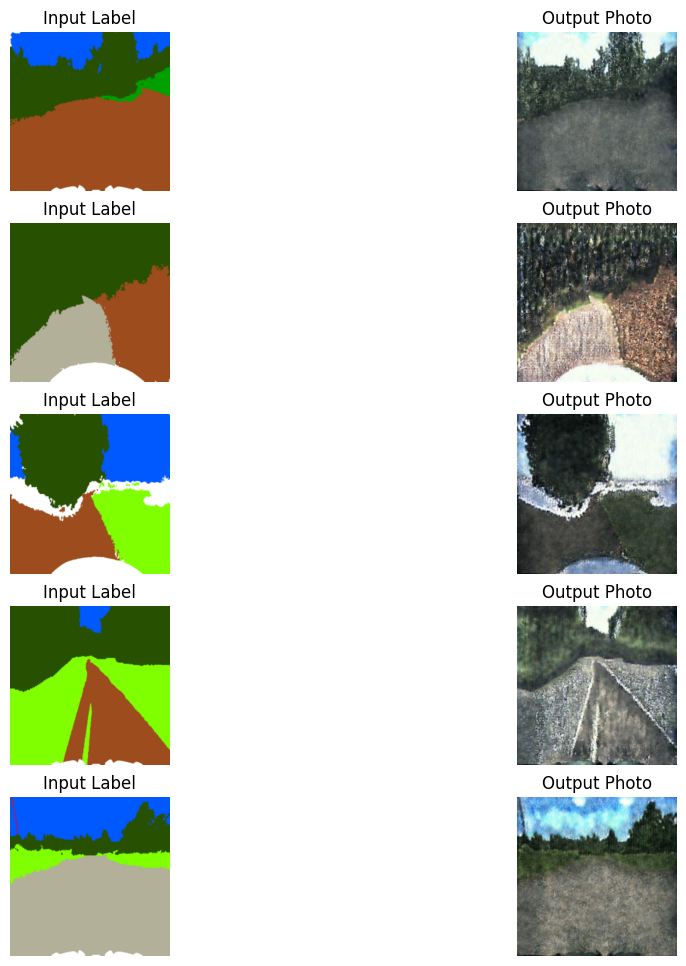

In [21]:
_, ax = plt.subplots(5, 2, figsize=(12, 12))
for i in range(5):
    photo_img,monet_img = next(iter(img_dl))
    pred_photo = gan.gen_mtp(monet_img.to(device)).cpu().detach()
    monet_img = unnorm(monet_img)
    pred_photo = unnorm(pred_photo)
    
    ax[i, 0].imshow(monet_img[0].permute(1, 2, 0))
    ax[i, 1].imshow( pred_photo[0].permute(1, 2, 0))
    ax[i, 0].set_title("Input Label")
    ax[i, 1].set_title("Output Photo")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")
plt.show()